In [1]:
import numpy as np
import sklearn
import pandas as pd
import time
import sys
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import Isomap
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Exploratory data analysis (EDA)

## Country Data

In [2]:
# Read cvs data in the "data" folder
train_df = pd.read_csv("data/Training.csv")
test_df = pd.read_csv("data/Testing.csv")

In [3]:
train_df.drop('Unnamed: 133', axis=1, inplace=True)
train_df.columns

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis'],
      dtype='object', length=133)

In [4]:
X_train = train_df.drop('prognosis', axis=1).values
y_train = train_df['prognosis'].values
# y_train = np.array(y_train).reshape(y_train.shape[0], 1)

X_test = test_df.drop('prognosis', axis=1).values
y_test = test_df['prognosis'].values
# y_test = np.array(y_test).reshape(y_test.shape[0], 1)

print("X_train : {} \ny_train : {} \nX_test: {} \ny_test : {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train : (4920, 132) 
y_train : (4920,) 
X_test: (42, 132) 
y_test : (42,)


In [5]:
# convert categorial to enumerate output
y_train_enc = pd.get_dummies(train_df['prognosis'])
y_test_enc = pd.get_dummies(test_df['prognosis'])

In [7]:
# Record performace: training time and test time, evaluation metrics
method = ['org', 'pca', 'ica', 'grp', 'iso']
attr = ['train_time', 'test_time', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
performance = pd.DataFrame(columns=attr, index=method)

In [8]:
len(test_df['prognosis'].unique())

41

# K Mean

In [9]:
%%time
# SSE (sum of Squares errors), ss (Silhoutte score), chs (Calinski harabasz score)
clusters = list(range(2,50))
sse_km = {}
ss_km = {}
chs_km = {}

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_train)
    labels = kmeans.predict(X_train)
    sse_km[k] = kmeans.inertia_
    ss_km[k] = silhouette_score(X_train, labels, metric='euclidean')
    chs_km[k] = calinski_harabasz_score(X_train, labels)

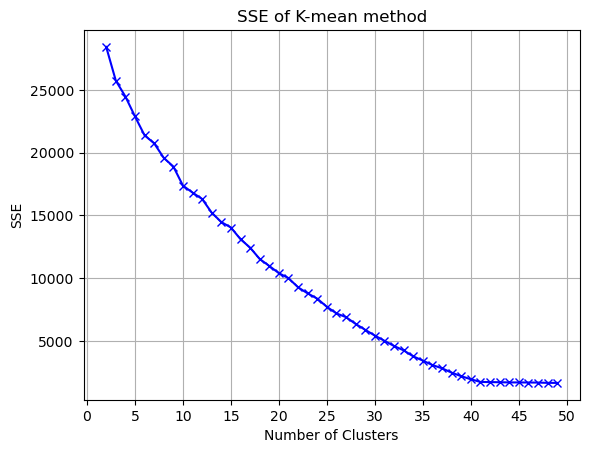

In [10]:
# Plotting SSE
plt.figure()
plt.plot(list(sse_km.keys()), list(sse_km.values()), "bx-")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.xticks(np.arange(0,51,5))
plt.title("SSE of K-mean method")
plt.grid()
plt.savefig('images/dp_km_sse.png')
plt.show()

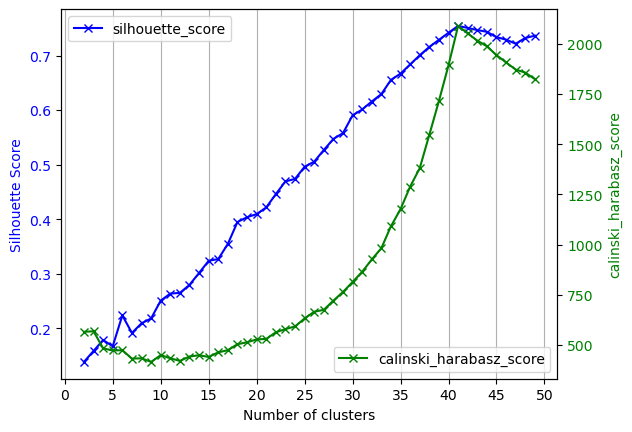

In [11]:
# Plotting scores
# silhouette_score
fig, ax1 = plt.subplots() 
ax1.set_xlabel('Number of clusters') 
ax1.set_ylabel('Silhouette Score', color = "b") 
ax1.plot(list(ss_km.keys()), list(ss_km.values()), "bx-", label='silhouette_score') 
ax1.tick_params(axis ='y', labelcolor = "b") 
 
# calinski_harabasz_score
ax2 = ax1.twinx() 
ax2.set_ylabel('calinski_harabasz_score', color = "g") 
ax2.plot(list(chs_km.keys()), list(chs_km.values()), "gx-", label='calinski_harabasz_score') 
ax2.tick_params(axis ='y', labelcolor = "g") 

ax1.legend(loc=2)
ax2.legend(loc=4)
plt.xticks(np.arange(0,51,5))
ax1.grid(axis='x')
plt.savefig('images/dp_km_scores.png')
plt.show()

In [12]:
# calinski_harabasz_score is highest for k = 41
kmeans = KMeans(n_clusters=41, random_state=1)
kmeans.fit(X_train)

# Adding predicted Labels to scaled data and original data
y_train_pred = kmeans.predict(X_train)
# data_without_country["kmean_labels"] = kmeans.predict(data_scaled)

# pd.DataFrame(y_train_pred).value_counts()

# EXPECTATION MAXIMIZATION

In [13]:
%%time
log_likelihood_em = {}
ss_em = {}
chs_em = {}
for k in clusters:
    gmm = GaussianMixture(n_components=k, max_iter=50, random_state=1, 
                          n_init=5).fit(X_train)
    label = gmm.predict(X_train)
    log_likelihood_em[k] = gmm.score(X_train)
    ss_em[k] = silhouette_score(X_train, label, metric='euclidean')
    chs_em[k] = calinski_harabasz_score(X_train, labels)

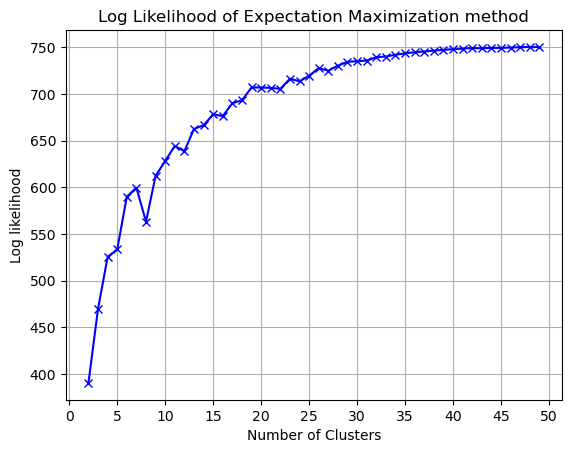

In [14]:
# Plot log likelihood
plt.figure()
plt.plot(list(ss_em.keys()), list(log_likelihood_em.values()), "bx-")
plt.xlabel("Number of Clusters")
plt.ylabel("Log likelihood")
plt.title("Log Likelihood of Expectation Maximization method")
plt.xticks(np.arange(0,51,5))
plt.grid()
plt.savefig('images/dp_em_likelihood.png')
plt.show()

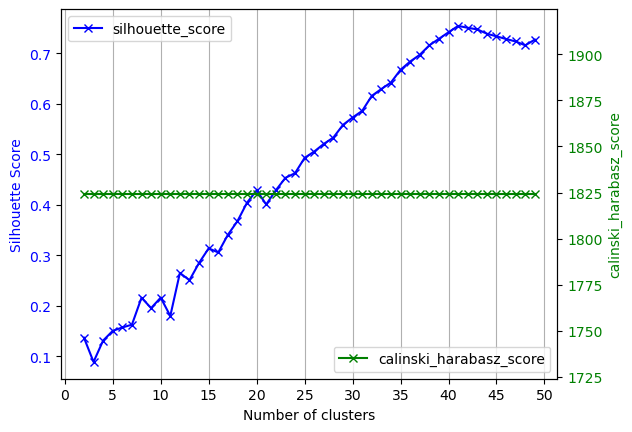

In [15]:
# Plotting scores
# silhouette_score
fig, ax1 = plt.subplots() 
ax1.set_xlabel('Number of clusters') 
ax1.set_ylabel('Silhouette Score', color = "b") 
ax1.plot(list(ss_em.keys()), list(ss_em.values()), "bx-", label='silhouette_score') 
ax1.tick_params(axis ='y', labelcolor = "b") 
 
# calinski_harabasz_score
ax2 = ax1.twinx() 
ax2.set_ylabel('calinski_harabasz_score', color = "g") 
ax2.plot(list(chs_em.keys()), list(chs_em.values()), "gx-", label='calinski_harabasz_score') 
ax2.tick_params(axis ='y', labelcolor = "g") 

ax1.legend(loc=2)
ax2.legend(loc=4)
plt.xticks(np.arange(0,51,5))
ax1.grid(axis='x')
plt.savefig('images/dp_em_scores.png')
plt.show()

# Neural Network for original data

In [50]:
# Neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(10, 41), random_state=1, max_iter=3000)

# Hyperparameter tuning using grid search
parameters = {'alpha':np.linspace(0.001, 1., 10),
              'learning_rate_init':np.linspace(0.01, .5, 10)}
nn_model_gs = GridSearchCV(nn_model, param_grid=parameters, cv=5, n_jobs=-1)
t0 = time.time()
nn_model_gs.fit(X_train, y_train)
t1 = time.time()
train_time = t1 - t0

best_nn_params = nn_model_gs.best_params_
best_nn_model = nn_model_gs.best_estimator_

t0 = time.time()
y_pred = best_nn_model.predict(X_test)
t1 = time.time()
test_time = t1 - t0
performance.loc['org'] = [train_time, test_time, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='weighted'),
                            recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')]
print("Best parameters set for neural networks:")
print(best_nn_params)
print('training time: %f seconds' % train_time)
print('testing time : %f seconds' % test_time)
print('neural network accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Best parameters set for neural networks:
{'alpha': 0.001, 'learning_rate_init': 0.01}
training time: 109.385545 seconds
testing time : 0.001514 seconds
neural network accuracy: 100.00%


# PCA

In [27]:
%%time
# Number of principal components
# n_comp = X_train.shape[1]
n_comp = 50

#Finding principal components for the data
pca = PCA(n_components=n_comp, random_state=1)
pca.fit_transform(X_train)


CPU times: total: 1.59 s
Wall time: 379 ms


array([[-0.71980326, -0.34661635, -0.26600067, ...,  0.01048036,
         0.01287812,  0.0193672 ],
       [-0.79505409, -0.28166055, -0.3302827 , ..., -0.02552718,
         0.13125048,  0.24124457],
       [-0.67269293, -0.36281236, -0.1456956 , ..., -0.01877764,
        -0.09629704,  0.22642361],
       ...,
       [-0.81991237, -0.33042762, -0.24901378, ...,  0.00778873,
         0.01229652, -0.01904367],
       [-0.66878558, -0.42470119, -0.47613984, ...,  0.00715747,
         0.00750566,  0.00598953],
       [-0.60063682,  0.06487598, -0.47286419, ...,  0.00840486,
         0.00648213,  0.00166481]])

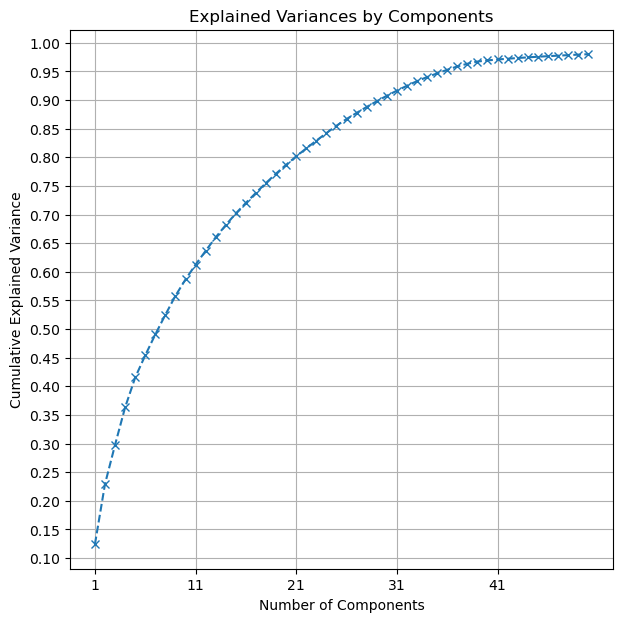

In [28]:
#The percentage of variance explained by each principal component
# exp_var = pca.explained_variance_
# visualize the Explained Individual Components
plt.figure(figsize = (7, 7))
plt.plot(np.arange(1,n_comp+1), pca.explained_variance_ratio_.cumsum(), marker = 'x', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.xticks(np.arange(1,n_comp+1, 10))
plt.yticks(np.linspace(0.1,1.0,19))
plt.grid()
plt.savefig('images/dp_pca_components.png')
plt.show()

In [60]:
pca.explained_variance_ratio_.cumsum()

array([0.12421203, 0.22940704, 0.29785016, 0.36330011, 0.4154111 ])

In [51]:
comp = 5
pca = PCA(n_components=comp, random_state=1)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [52]:
# Neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(10, 41), random_state=1, max_iter=3000)

# Hyperparameter tuning using grid search
parameters = {'alpha':np.linspace(0.001, 1., 10),
              'learning_rate_init':np.linspace(0.01, .5, 10)}
nn_model_gs = GridSearchCV(nn_model, param_grid=parameters, cv=5, n_jobs=-1)
t0 = time.time()
nn_model_gs.fit(X_train_pca, y_train)
t1 = time.time()
train_time = t1 - t0

best_nn_params = nn_model_gs.best_params_
best_nn_model = nn_model_gs.best_estimator_

t0 = time.time()
y_pred = best_nn_model.predict(X_test_pca)
t1 = time.time()
test_time = t1 - t0
performance.loc['pca'] = [train_time, test_time, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='weighted'),
                            recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')]
print("Best parameters set for neural networks:")
print(best_nn_params)
print('training time: %f seconds' % train_time)
print('testing time : %f seconds' % test_time)
print('neural network accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Best parameters set for neural networks:
{'alpha': 0.001, 'learning_rate_init': 0.01}
training time: 94.972726 seconds
testing time : 0.000960 seconds
neural network accuracy: 100.00%


# ICA

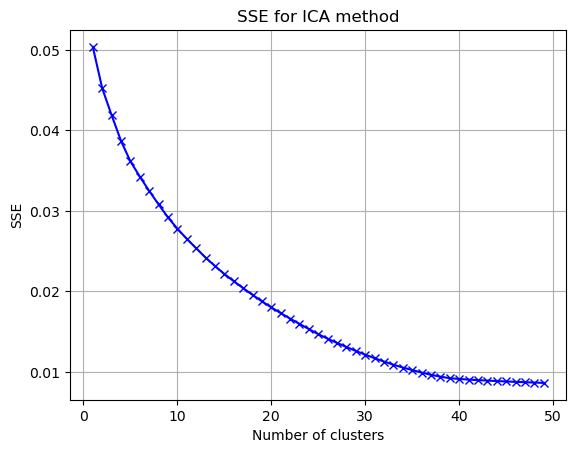

CPU times: total: 1min 13s
Wall time: 26.5 s


In [31]:
%%time
# reconstruction error
rc_errors = {}
for k in np.arange(1,n_comp):
    ica = FastICA(n_components=k, random_state=1)
    x_prime = ica.fit_transform(X_train)
    
    # reconstruction
    A = np.linalg.pinv(ica.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(X_train, reconstructed)    
    rc_errors[k] = rc_err
#     print(dim, ": ", rc_err)
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()), 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("SSE for ICA method")
plt.grid()
plt.savefig('images/dp_ica_sse.png')
plt.show()

In [53]:
comp = 5
ica = FastICA(n_components=comp, random_state=1, max_iter=1000)
ica.fit(X_train)
X_train_ica = ica.transform(X_train)
X_test_ica = ica.transform(X_test)

In [54]:
# Neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(10, 41), random_state=1, max_iter=3000)

# Hyperparameter tuning using grid search
parameters = {'alpha':np.linspace(0.001, 1., 10),
              'learning_rate_init':np.linspace(0.01, .5, 10)}
nn_model_gs = GridSearchCV(nn_model, param_grid=parameters, cv=5, n_jobs=-1)
t0 = time.time()
nn_model_gs.fit(X_train_ica, y_train)
t1 = time.time()
train_time = t1 - t0

best_nn_params = nn_model_gs.best_params_
best_nn_model = nn_model_gs.best_estimator_

t0 = time.time()
y_pred = best_nn_model.predict(X_test_ica)
t1 = time.time()
test_time = t1 - t0
performance.loc['ica'] = [train_time, test_time, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='weighted'),
                            recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')]
print("Best parameters set for neural networks:")
print(best_nn_params)
print('training time: %f seconds' % train_time)
print('testing time : %f seconds' % test_time)
print('neural network accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Best parameters set for neural networks:
{'alpha': 0.001, 'learning_rate_init': 0.01}
training time: 98.742740 seconds
testing time : 0.013029 seconds
neural network accuracy: 97.62%


# Randomized Projections

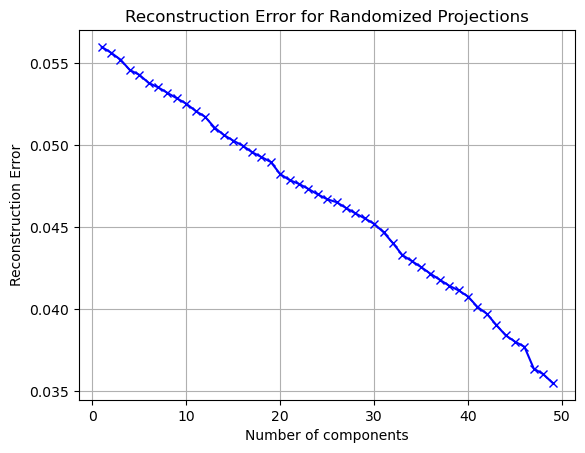

CPU times: total: 938 ms
Wall time: 1.66 s


In [61]:
%%time
# reconstruction error
rc_errors = {}
for k in np.arange(1,n_comp):
    grp = GaussianRandomProjection(n_components=k, random_state=1)
    x_prime = grp.fit_transform(X_train)
    
    # reconstruction
    A = np.linalg.pinv(grp.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(X_train, reconstructed)    
    rc_errors[k] = rc_err
#     print(dim, ": ", rc_err)
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()), 'bx-')
plt.xlabel("Number of components")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error for Randomized Projections")
plt.grid()
plt.savefig('images/dp_rp_re.png')
plt.show()

In [55]:
comp = 5
grp = GaussianRandomProjection(n_components=comp, random_state=1)
grp.fit(X_train)
X_train_grp = grp.transform(X_train)
X_test_grp = grp.transform(X_test)

In [56]:
# Neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(10, 41), random_state=1, max_iter=3000)

# Hyperparameter tuning using grid search
parameters = {'alpha':np.linspace(0.001, 1., 10),
              'learning_rate_init':np.linspace(0.01, .5, 10)}
nn_model_gs = GridSearchCV(nn_model, param_grid=parameters, cv=5, n_jobs=-1)
t0 = time.time()
nn_model_gs.fit(X_train_grp, y_train)
t1 = time.time()
train_time = t1 - t0

best_nn_params = nn_model_gs.best_params_
best_nn_model = nn_model_gs.best_estimator_

t0 = time.time()
y_pred = best_nn_model.predict(X_test_grp)
t1 = time.time()
test_time = t1 - t0
performance.loc['grp'] = [train_time, test_time, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='weighted'),
                            recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')]
print("Best parameters set for neural networks:")
print(best_nn_params)
print('training time: %f seconds' % train_time)
print('testing time : %f seconds' % test_time)
print('neural network accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Best parameters set for neural networks:
{'alpha': 0.001, 'learning_rate_init': 0.01}
training time: 84.968232 seconds
testing time : 0.000731 seconds
neural network accuracy: 97.62%


# Manifold Learning Algorithm: Isomap Embedding

In [37]:
%%time
# reconstruction error
rc_errors = {}
for k in np.arange(2,n_comp):
    iso = Isomap(n_components=k, n_neighbors=5)
    x_prime = iso.fit_transform(X_train)    
    rc_errors[k] = iso.reconstruction_error()

CPU times: total: 1h 14s
Wall time: 1h 16min 58s


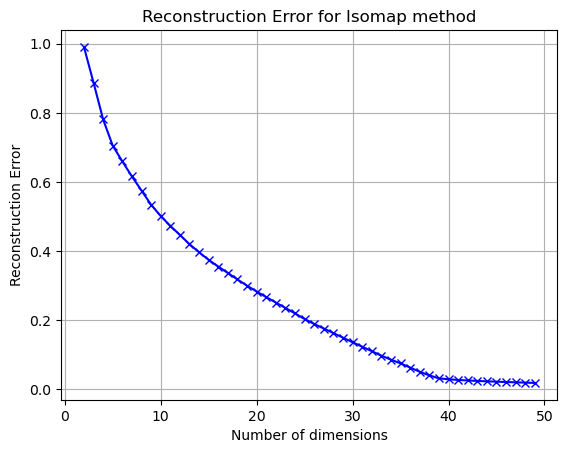

In [38]:
# Plot
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()), 'bx-')
plt.xlabel("Number of dimensions")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error for Isomap method")
plt.grid()
plt.savefig('images/dp_iso_re.png')
plt.show()

In [47]:
comp = 5
iso = Isomap(n_components=comp, n_neighbors=5)
iso.fit(X_train)
X_train_iso = iso.transform(X_train)
X_test_iso = iso.transform(X_test)

In [57]:
# Neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(10, 41), random_state=1, max_iter=3000)

# Hyperparameter tuning using grid search
parameters = {'alpha':np.linspace(0.001, 1., 10),
              'learning_rate_init':np.linspace(0.01, .5, 10)}
nn_model_gs = GridSearchCV(nn_model, param_grid=parameters, cv=5, n_jobs=-1)
t0 = time.time()
nn_model_gs.fit(X_train_iso, y_train)
t1 = time.time()
train_time = t1 - t0

best_nn_params = nn_model_gs.best_params_
best_nn_model = nn_model_gs.best_estimator_

t0 = time.time()
y_pred = best_nn_model.predict(X_test_iso)
t1 = time.time()
test_time = t1 - t0
performance.loc['iso'] = [train_time, test_time, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='weighted'),
                            recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')]
print("Best parameters set for neural networks:")
print(best_nn_params)
print('training time: %f seconds' % train_time)
print('testing time : %f seconds' % test_time)
print('neural network accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Best parameters set for neural networks:
{'alpha': 0.001, 'learning_rate_init': 0.01}
training time: 95.595280 seconds
testing time : 0.000000 seconds
neural network accuracy: 97.62%


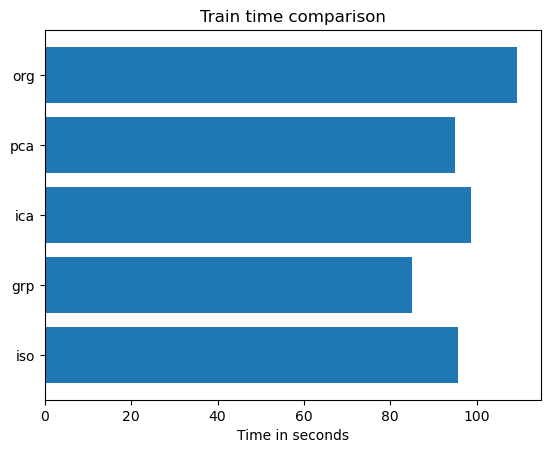

In [58]:
# Classifier comparison: Train time
y_pos = np.arange(len(method))
plt.figure()
plt.barh(y_pos, performance['train_time'])
plt.gca().set_yticks(y_pos)
plt.gca().set_yticklabels(method)
plt.gca().invert_yaxis()
plt.title('Train time comparison')
plt.xlabel('Time in seconds')
plt.savefig('images/dp_train_time_comparison.png')
plt.show()

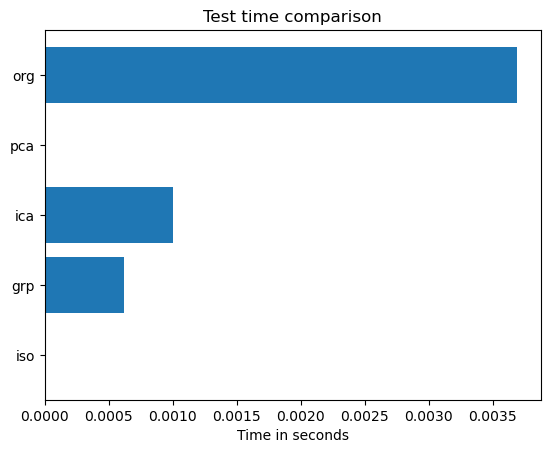

In [44]:
# Classifier comparison: Test time
y_pos = np.arange(len(method))
plt.figure()
plt.barh(y_pos, performance['test_time'])
plt.gca().set_yticks(y_pos)
plt.gca().set_yticklabels(method)
plt.gca().invert_yaxis()
plt.title('Test time comparison')
plt.xlabel('Time in seconds')
plt.savefig('images/dp_test_time_comparison.png')
plt.show()

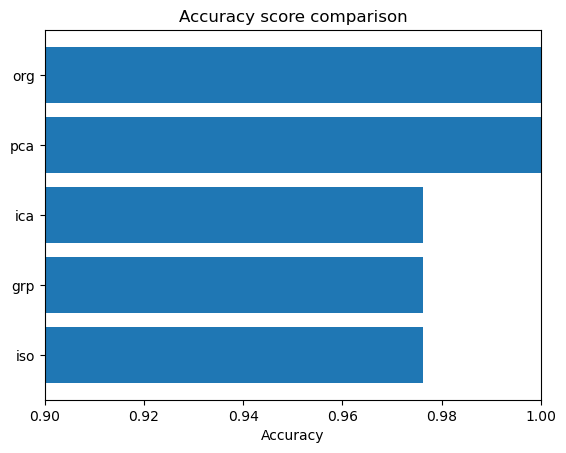

In [59]:
# Classifier comparison
y_pos = np.arange(len(method))
plt.figure()
plt.barh(y_pos, performance['accuracy_score'])
plt.gca().set_yticks(y_pos)
plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(method)
plt.gca().invert_yaxis()
plt.title('Accuracy score comparison')
plt.xlabel('Accuracy')
plt.savefig('images/dp_accuracy_score_comparison.png')
plt.show()